In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import torch

2024-03-10 10:45:33.752996: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-10 10:45:33.753111: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-10 10:45:33.885435: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train = pd.read_csv("/kaggle/input/data-train-test/train_data.csv")
test = pd.read_csv("/kaggle/input/data-train-test/test_data.csv")

In [3]:
train.head()

,ID,filename,texte,sexe,date_accident,date_consolidation
0,0,Agen_100515.txt,Le : 12/11/2019\n \n \nCour d’appel d’Agen \n ...,homme,1991-04-09,n.c.
1,1,Agen_1100752.txt,Le : 12/11/2019\n \n \nCour d’appel d’Agen \n ...,homme,2005-06-10,2010-01-19
2,2,Agen_1613.txt,Le : 12/11/2019\n \n \nCour d’appel d’Agen \n ...,femme,1997-09-26,n.c.
3,3,Agen_2118.txt,Le : 12/11/2019\n \n \nCour d’appel d’Agen \n ...,femme,1982-08-07,1982-11-07
4,4,Agen_21229.txt,Le : 12/11/2019\n \n \nCour d’appel d’Agen \n ...,homme,1996-11-26,n.c.


In [4]:
def remove_newlines(df):
    df = df.replace("\n", '', regex=True)
    return df
train = remove_newlines(train)
test = remove_newlines(test)

In [5]:
train.head()

,ID,filename,texte,sexe,date_accident,date_consolidation
0,0,Agen_100515.txt,Le : 12/11/2019 Cour d’appel d’Agen chambre ...,homme,1991-04-09,n.c.
1,1,Agen_1100752.txt,Le : 12/11/2019 Cour d’appel d’Agen chambre ...,homme,2005-06-10,2010-01-19
2,2,Agen_1613.txt,Le : 12/11/2019 Cour d’appel d’Agen Audience...,femme,1997-09-26,n.c.
3,3,Agen_2118.txt,Le : 12/11/2019 Cour d’appel d’Agen Audience...,femme,1982-08-07,1982-11-07
4,4,Agen_21229.txt,Le : 12/11/2019 Cour d’appel d’Agen Audience...,homme,1996-11-26,n.c.


In [6]:
for col in ["sexe", "date_accident", "date_consolidation"]:
    print("\n","-"*5, col, "-"*5)
    print(train[col].value_counts(normalize=True)*100)


 ----- sexe -----
sexe
homme    72.597403
femme    26.753247
n.c.      0.649351
Name: proportion, dtype: float64

 ----- date_accident -----
date_accident
n.c.          3.506494
2002-06-13    0.389610
2005-10-25    0.389610
1995-07-27    0.259740
2004-08-08    0.259740
                ...   
2007-05-24    0.129870
2010-05-06    0.129870
2008-09-26    0.129870
2009-10-12    0.129870
2007-10-13    0.129870
Name: proportion, Length: 697, dtype: float64

 ----- date_consolidation -----
date_consolidation
n.c.          28.441558
n.a.          13.246753
2004-09-15     0.389610
2005-03-02     0.389610
2007-09-24     0.389610
                ...    
2005-06-12     0.129870
1996-06-14     0.129870
1993-07-16     0.129870
2009-02-15     0.129870
2006-04-28     0.129870
Name: proportion, Length: 413, dtype: float64


In [7]:
train = train[train["sexe"] != 'n.c.']

(array([559.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 206.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

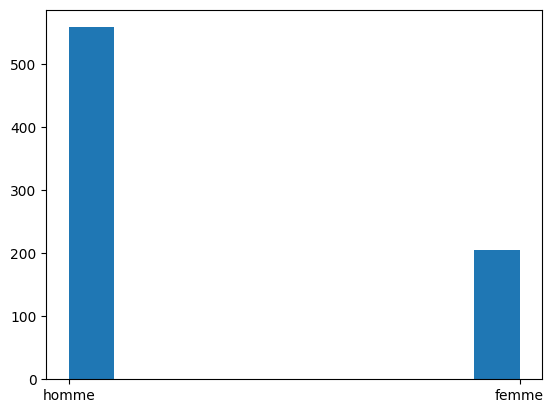

In [8]:
import matplotlib.pyplot as plt

plt.hist(train["sexe"])

In [9]:
train = train.drop(["date_accident", "date_consolidation"], axis=1)

In [10]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('french')
train['texte'] = train["texte"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
# train['sexe'].replace({"homme":0,"femme":1},inplace=True)

In [12]:
train = train.drop(["ID", "filename"], axis=1)

In [13]:
train['text_id'] = np.arange(len(train))
test["text_id"] = np.arange(len(test))

In [14]:
train

,texte,sexe,text_id
0,Le : 12/11/2019 Cour d’appel d’Agen chambre so...,homme,0
1,Le : 12/11/2019 Cour d’appel d’Agen chambre ci...,homme,1
2,Le : 12/11/2019 Cour d’appel d’Agen Audience p...,femme,2
3,Le : 12/11/2019 Cour d’appel d’Agen Audience p...,femme,3
4,Le : 12/11/2019 Cour d’appel d’Agen Audience p...,homme,4
...,...,...,...
765,Le : 12/11/2019 Cour d’appel Versailles ct0032...,homme,760
766,Le : 12/11/2019 Cour d’appel Versailles ct0087...,femme,761
767,Le : 12/11/2019 Cour d’appel Versailles ct0087...,homme,762
768,Le : 12/11/2019 Cour d’appel Versailles ct0087...,homme,763


In [15]:
# train["sexe"] = train["sexe"].replace({"homme":1, "femme":0})

In [16]:
from torch.utils.data import Dataset

class JuridiqueDataset_train(Dataset):
    def __init__(self,
                 df,
                 tokenizer,
                 args
                ):
        # args is a dict, a nice way to share the global arguments (even accross multiple files)
        self.args = args
        self.tokenizer = tokenizer
        self.df = df
        
    def make_one_item(self,idx):
        # this function should encode (tokenize) a given text 
        text_id = self.df.iloc[idx].text_id
        text = self.df.iloc[idx].texte
        sexe = self.df.iloc[idx].sexe
        tokenizer_encoding = self.tokenizer(text, max_length=512)
        outputs = dict(**tokenizer_encoding)
        
        outputs['text_id'] = text_id
        outputs['sexe'] = sexe
        
        return outputs
    
    def __len__(self) -> int:
        return len(self.df)
    
    def __getitem__(self,idx):
        return self.make_one_item(idx)

In [17]:

class JuridiqueDataset_test(Dataset):
    def __init__(self,
                 df,
                 tokenizer,
                 args
                ):
        # args is a dict, a nice way to share the global arguments (even accross multiple files)
        self.args = args
        self.tokenizer = tokenizer
        self.df = df
        
    def make_one_item(self,idx):
        # this function should encode (tokenize) a given text 
        text_id = self.df.iloc[idx].text_id
        text = self.df.iloc[idx].texte
        # sexe = self.df.iloc[idx].sexe
        tokenizer_encoding = self.tokenizer(text, max_length=512)
        outputs = dict(**tokenizer_encoding)
        
        outputs['text_id'] = text_id
        # outputs['sexe'] = sexe
        
        return outputs
    
    def __len__(self) -> int:
        return len(self.df)
    
    def __getitem__(self,idx):
        return self.make_one_item(idx)

In [18]:
from transformers import AutoTokenizer
# Apply your dataset module to allocine data with bert-base-uncased tokenizer
# randomly generate some examples through your dataset (dataset created from AllocineDataset)
model_name = "almanach/camembert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/508 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

In [19]:
import random
args = {}
ds = JuridiqueDataset_train(train,tokenizer,args)
idx = random.choice(range(len(ds)))
# ds[idx]
# print(tokenizer.convert_ids_to_tokens(ds[idx]['input_ids']))

# DataLoader

In [20]:
from torch.utils.data import DataLoader

In [21]:
## =============================================================================== ##
class CustomCollator_train():
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def __call__(self, batch):
        output = dict()
        output["input_ids"] = [sample["input_ids"] for sample in batch]
        output["attention_mask"] = [sample["attention_mask"] for sample in batch]
        output["sexe"] = [sample["sexe"] for sample in batch]
        output["text_id"] = [sample["text_id"] for sample in batch]


        batch_max = max([len(ids) for ids in output["input_ids"]])

        # add padding
        if self.tokenizer.padding_side == "right":
            output["input_ids"] = [s + (batch_max - len(s)) * [self.tokenizer.pad_token_id] for s in output["input_ids"]]
            output["attention_mask"] = [s + (batch_max - len(s)) * [0] for s in output["attention_mask"]]

        else:

            output["input_ids"] = [(batch_max - len(s)) * [self.tokenizer.pad_token_id] + s for s in output["input_ids"]]
            output["attention_mask"] = [(batch_max - len(s)) * [0] + s for s in output["attention_mask"]]

        # convert to tensors
        output["input_ids"] = torch.tensor(output["input_ids"], dtype=torch.long)
        output["attention_mask"] = torch.tensor(output["attention_mask"], dtype=torch.long)
        
        sexe_to_int = {"homme": 0, "femme": 1}
        output["sexe"] = torch.tensor([sexe_to_int[item] for item in output["sexe"]], dtype=torch.long)
        # output["sexe"] = torch.tensor(output["sexe"], dtype=torch.long)#.unsqueeze(-1) #mettre float au lieu de long
        output["text_id"] = torch.tensor(output["text_id"], dtype=torch.long)
        return output
    
    ## =============================================================================== ##
class CustomCollator_test():
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def __call__(self, batch):
        output = dict()
        output["input_ids"] = [sample["input_ids"] for sample in batch]
        output["attention_mask"] = [sample["attention_mask"] for sample in batch]
        # output["sexe"] = [sample["sexe"] for sample in batch]
        output["text_id"] = [sample["text_id"] for sample in batch]


        batch_max = max([len(ids) for ids in output["input_ids"]])

        # add padding
        if self.tokenizer.padding_side == "right":
            output["input_ids"] = [s + (batch_max - len(s)) * [self.tokenizer.pad_token_id] for s in output["input_ids"]]
            output["attention_mask"] = [s + (batch_max - len(s)) * [0] for s in output["attention_mask"]]

        else:

            output["input_ids"] = [(batch_max - len(s)) * [self.tokenizer.pad_token_id] + s for s in output["input_ids"]]
            output["attention_mask"] = [(batch_max - len(s)) * [0] + s for s in output["attention_mask"]]

        # convert to tensors
        output["input_ids"] = torch.tensor(output["input_ids"], dtype=torch.long)
        output["attention_mask"] = torch.tensor(output["attention_mask"], dtype=torch.long)
        
        # sexe_to_int = {"homme": 0, "femme": 1}
        # output["sexe"] = torch.tensor([sexe_to_int[item] for item in output["sexe"]], dtype=torch.long)
        # output["sexe"] = torch.tensor(output["sexe"], dtype=torch.long)#.unsqueeze(-1) #mettre float au lieu de long
        output["text_id"] = torch.tensor(output["text_id"], dtype=torch.long)
        return output

In [22]:
collator_function = CustomCollator_train(tokenizer)
my_dataset = JuridiqueDataset_train(train,tokenizer,args)

In [23]:
data_loader = DataLoader(my_dataset,drop_last = False,num_workers=0,pin_memory=False,shuffle=False,
                              batch_size = 2,collate_fn = collator_function)

In [24]:
from tqdm import tqdm
for batch in tqdm(data_loader):
    break

  0%|          | 0/383 [00:00<?, ?it/s]


In [25]:
batch['input_ids'].shape,batch['sexe'].shape,batch['attention_mask'].shape

(torch.Size([2, 512]), torch.Size([2]), torch.Size([2, 512]))

In [26]:
batch['attention_mask']

tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])

In [27]:
import torch.nn as nn
from transformers import AutoConfig, AutoModel
import torch.utils.checkpoint
import torch.nn.functional as F

class MyBertModel(nn.Module):
    def __init__(self, model_name="almanach/camembert-base", num_labels=2):
        super().__init__()
        self.config = AutoConfig.from_pretrained(model_name, output_hidden_states=True)        
        self.backbone = AutoModel.from_pretrained(model_name)
        self.fc = nn.Linear(self.config.hidden_size, num_labels)

    def forward(self, batch):
        inputs = {k: v for k, v in batch.items() if k in ['input_ids', 'attention_mask']}
        outputs = self.backbone(**inputs)
        x = outputs.last_hidden_state[:, 0, :]
        x = self.fc(x)
        return x


In [28]:
def train_one_step(batch,model,criterion):
    """
    Complete this function which should return the loss generate on the bacth data
    """
    # convert bacth data to same device as model
    device  = torch.device(f"cuda:0" if torch.cuda.is_available() else "cpu")
    batch = batch_to_device(batch,device)
    # one step forward with the bacth
    pred = model(batch)
    
    # compute loss 
    loss = criterion(pred.squeeze(),batch['sexe'].float().squeeze(-1))
#     print(loss)
    return loss

In [29]:
def train_one_epoch(epoch_number,data_loader,model,criterion,optimzer,lr_scheduler):
    losses = []
    model.train()
    start_time = time.time()
    pbar = tqdm(data_loader)
    for batch in pbar:
        loss = train_one_step(batch,model,criterion)
        pbar.set_postfix({"loss":loss.item()})
        losses.append(loss.item())
        loss.backward()
        optimzer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
    
    lr = scheduler.get_lr()[0]
    elapsed_time = time.time() - start_time
    loss_ = np.mean(losses)
    print(f"Epoch {epoch_number + 1} :  lr={lr:.6f} t={elapsed_time:.0f}s loss : {loss_:.5f}")
    return model

In [30]:

def inference(valid_loader, model):
    predictions = []
    model.eval()  # Met le modèle en mode évaluation.
    
    device = next(model.parameters()).device
    
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            batch = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}
            pred = model(batch).sigmoid().squeeze()
            
            if pred.dim() == 0:
                pred = pred.unsqueeze(0)
            
            predictions.append(pred.detach().cpu().numpy())
    
    predictions = np.concatenate(predictions, axis=0)
    
    df_predict = pd.DataFrame({"sexe_pred": predictions.tolist()})
    return df_predict

In [31]:
def batch_to_device(batch, device):
    """Déplace uniquement les tenseurs du batch vers le dispositif spécifié."""
    batch_dict = {}
    for key in batch:
        # Vérifier si l'élément est un tenseur avant de tenter de le déplacer
        if isinstance(batch[key], torch.Tensor):
            batch_dict[key] = batch[key].to(device)
        else:
            # Si ce n'est pas un tenseur, simplement copier l'élément tel quel
            batch_dict[key] = batch[key]
    return batch_dict


In [32]:
# Define your model
device = torch.device(f"cuda:0" if torch.cuda.is_available() else "cpu")
net = MyBertModel(model_name=model_name,num_labels=1)
net.to(device)

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

MyBertModel(
  (backbone): CamembertModel(
    (embeddings): CamembertEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): CamembertEncoder(
      (layer): ModuleList(
        (0-11): 12 x CamembertLayer(
          (attention): CamembertAttention(
            (self): CamembertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): CamembertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (Laye

In [33]:
# Define an optimzer 
import torch.optim as optim

optimizer = optim.AdamW(net.parameters(),lr = 4e-6 )

In [34]:
# Define a scheduller for your model training
from transformers import get_linear_schedule_with_warmup,get_cosine_schedule_with_warmup

BATCH_SIZE = 6
EPOCHS = 8
warmup_steps = 0.04 * (len(train)//BATCH_SIZE)
training_steps = EPOCHS * (len(train)// (BATCH_SIZE))

scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, training_steps)

In [35]:
warmup_steps,training_steps

(5.08, 1016)

In [37]:
import time

criterion = nn.BCEWithLogitsLoss().to(device)
for epoch_num in range(EPOCHS):
    net = train_one_epoch(epoch_num,data_loader,net,criterion,optimizer,scheduler)

100%|██████████| 383/383 [01:28<00:00,  4.33it/s, loss=0.324]


Epoch 1 :  lr=0.000000 t=89s loss : 0.58086


100%|██████████| 383/383 [01:28<00:00,  4.33it/s, loss=0.312]


Epoch 2 :  lr=0.000001 t=88s loss : 0.58117


100%|██████████| 383/383 [01:28<00:00,  4.35it/s, loss=0.302]


Epoch 3 :  lr=0.000003 t=88s loss : 0.58070


100%|██████████| 383/383 [01:28<00:00,  4.33it/s, loss=0.164]


Epoch 4 :  lr=0.000004 t=88s loss : 0.43842


100%|██████████| 383/383 [01:28<00:00,  4.32it/s, loss=0.178]


Epoch 5 :  lr=0.000002 t=89s loss : 0.29552


100%|██████████| 383/383 [01:28<00:00,  4.33it/s, loss=0.135]


Epoch 6 :  lr=0.000000 t=88s loss : 0.24307


100%|██████████| 383/383 [01:28<00:00,  4.33it/s, loss=0.131]


Epoch 7 :  lr=0.000001 t=88s loss : 0.22970


100%|██████████| 383/383 [01:28<00:00,  4.33it/s, loss=0.123]

Epoch 8 :  lr=0.000003 t=88s loss : 0.22800


In [48]:
collator_function = CustomCollator_test(tokenizer)
valid_dataset = JuridiqueDataset_test(test,tokenizer,args)
valid_loader = DataLoader(valid_dataset,drop_last = False,num_workers=0,pin_memory=False,shuffle=False,
                              batch_size = 6,collate_fn = collator_function)

In [49]:
pred_df = inference(valid_loader,net)

100%|██████████| 43/43 [00:13<00:00,  3.23it/s]


# TF-IDF

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn import metrics
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
from sklearn.model_selection import train_test_split
X = train[["texte", 'text_id']]

vect = TfidfVectorizer(
  max_features=5000,
  stop_words=list(fr_stop), binary=True)

X = vect.fit_transform(train['texte'])
train["sexe"] = train["sexe"].replace({'homme':0, "femme":1})
y = train['sexe']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = LogisticRegression(random_state=26).fit(X, y)

preds = clf.predict((X_test))

print("f1:", f1_score(y_test, preds, average='macro'))

fpr, tpr, thresholds = metrics.roc_curve(y_test, preds)
print("AUC: ", metrics.auc(fpr, tpr))

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['neuf', 'qu', 'quelqu'] not in stop_words.
  warnings.warn(


f1: 0.5647058823529412
AUC:  0.5795454545454546


# Embedding + fine tuning

In [51]:
import torch.nn as nn
from transformers import AutoConfig, AutoModel
import torch.utils.checkpoint
import torch.nn.functional as F

class MyEmbeddingModel(nn.Module):
    def __init__(self,
                 model_name="flaubert/flaubert_base_uncased"
                 ):
        super().__init__()

        self.config = AutoConfig.from_pretrained(model_name, output_hidden_states=True)        
        self.backbone = AutoModel.from_pretrained(model_name)

    def forward(self,batch):
        x = self.backbone(input_ids=batch["input_ids"],attention_mask=batch["attention_mask"]).last_hidden_state
        # Taking only CLS output for sentence classification
        x = x[:,0,:]
        return x

In [52]:

def get_embeddings(model, df):
    # Assumant que CustomCollator_test, JuridiqueDataset_test, et batch_to_device sont définis ailleurs
    collator_function = CustomCollator_test(tokenizer)
    valid_dataset = JuridiqueDataset_test(df, tokenizer, args)  # Remplacez `test` par `df` si `df` est votre DataFrame/variable d'entrée
    valid_loader = DataLoader(valid_dataset, drop_last=False, num_workers=0, pin_memory=False, shuffle=False,
                              batch_size=2, collate_fn=collator_function)
    
    embed_predictions = []
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    model.eval()
    with torch.no_grad():  # Désactiver les calculs de gradient pour l'inférence
        for batch in tqdm(valid_loader):
            batch = batch_to_device(batch, device)
            pred = model(batch)
            # Assurez-vous que pred a toujours 2 dimensions
            if pred.dim() == 1:
                pred = pred.unsqueeze(0)
            pred = pred.detach().cpu().numpy()
            embed_predictions.append(pred)
    
    embeddings = np.concatenate(embed_predictions, axis=0)
    df_predict = pd.DataFrame(embeddings)  # Vous devrez peut-être ajuster cette ligne en fonction de la structure exacte de vos données
    
    return df_predict

In [53]:
# Define your model
device = torch.device(f"cuda:0" if torch.cuda.is_available() else "cpu")
net = MyEmbeddingModel(model_name=model_name)
net.to(device)

MyEmbeddingModel(
  (backbone): CamembertModel(
    (embeddings): CamembertEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): CamembertEncoder(
      (layer): ModuleList(
        (0-11): 12 x CamembertLayer(
          (attention): CamembertAttention(
            (self): CamembertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): CamembertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              

In [54]:
df_embed_train = get_embeddings(net,train)

100%|██████████| 383/383 [00:33<00:00, 11.52it/s]


In [55]:
df_embed_train

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.053011,0.166661,0.058750,0.231161,-0.034837,0.057159,0.008483,0.118151,-0.061248,0.045353,...,0.026767,0.034264,-0.012110,0.111819,0.039565,-0.028171,-0.154299,-0.168557,0.073480,-0.022342
1,-0.066578,0.228916,-0.023085,0.191473,-0.029401,0.016115,-0.034092,0.125263,-0.053051,0.069131,...,0.032451,0.048909,-0.046211,0.107168,0.019107,-0.017993,-0.159349,-0.167348,0.118990,-0.034464
2,-0.041889,0.157754,0.027409,0.233111,-0.045690,0.016605,0.001600,0.116849,-0.038807,0.056699,...,0.016943,0.046952,0.005104,0.114351,0.039171,-0.049124,-0.205128,-0.188495,0.085562,-0.041652
3,-0.007722,0.186229,0.052269,0.220893,-0.021999,0.042606,-0.005421,0.120826,-0.031815,0.051929,...,0.004219,0.057078,-0.061195,0.127011,0.066782,-0.010784,-0.160560,-0.176241,0.135467,-0.008193
4,-0.054506,0.197065,0.026809,0.193647,-0.020644,0.011269,-0.031566,0.140709,-0.014331,0.061200,...,0.023733,-0.007234,0.004598,0.138585,0.046910,-0.024320,-0.171208,-0.147630,0.115746,-0.040100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
760,0.017110,0.189999,0.035954,0.196479,0.032863,0.067324,-0.028772,0.144655,0.019074,0.023254,...,-0.056535,-0.012065,-0.099690,0.156556,-0.027059,-0.009490,-0.106916,-0.168025,0.104594,-0.018467
761,-0.020720,0.176885,0.066307,0.232115,-0.034848,0.047415,-0.004769,0.109422,-0.022343,0.042124,...,0.007435,-0.001697,-0.073582,0.137719,0.047119,-0.018860,-0.161260,-0.147326,0.088928,-0.028378
762,0.012596,0.232736,0.086343,0.226421,-0.043727,0.050535,-0.007694,0.167672,-0.069338,0.057644,...,0.034067,0.057129,-0.025944,0.111654,-0.011729,0.004388,-0.148219,-0.153721,0.116613,-0.043920
763,-0.032219,0.216234,0.034283,0.217577,-0.051479,-0.011350,-0.020394,0.118757,-0.020196,0.032670,...,0.019180,-0.013225,-0.021431,0.144113,0.042651,0.005780,-0.171688,-0.174505,0.139839,-0.048927


In [66]:
X=df_embed_train

# y=train['sexe']
# train["sexe"].replace({"homme":0, "femme":1}, inplace=True)
y = train['sexe']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = LogisticRegression(random_state=26).fit(X, y)

preds= clf.predict(X_test)

fpr, tpr, thresholds = metrics.roc_curve(y_test, preds)
print("AUC: ",metrics.auc(fpr, tpr))

print("F1: ", f1_score(y_test, preds, average='macro'))
# print(f1_score(y_test, (pred_df["sexe_pred"].values>0.5)*1, average='macro'))


AUC:  0.5635946622185154
F1:  0.5411764705882353


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [69]:
X_test

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
357,0.008450,0.175297,0.006828,0.222527,-0.022800,0.038912,-0.011014,0.136758,-0.069220,0.055646,...,-0.019995,0.049186,-0.067075,0.104231,0.052251,0.037107,-0.147169,-0.154660,0.083329,-0.038886
259,-0.041648,0.267954,0.050232,0.171575,-0.014504,0.035172,-0.011602,0.123324,-0.019201,0.099488,...,-0.009551,-0.006824,-0.061646,0.134376,0.011433,0.018874,-0.144061,-0.158923,0.138762,-0.051799
751,-0.079703,0.211683,0.006514,0.241371,0.014056,-0.004454,-0.040448,0.141731,-0.017457,0.043284,...,0.025158,-0.006539,-0.016201,0.131315,-0.006621,-0.037080,-0.123813,-0.125377,0.084792,-0.044691
193,0.023601,0.192810,0.043783,0.146961,-0.026103,0.076152,0.000844,0.161031,-0.024403,0.024968,...,-0.009488,-0.056921,-0.127872,0.108799,0.090147,0.051756,-0.131189,-0.141939,0.137297,0.000827
333,-0.037775,0.251438,0.029225,0.191056,-0.023232,0.046038,-0.016886,0.124778,-0.016784,0.088705,...,0.006154,-0.013823,-0.042597,0.128750,0.016591,0.003557,-0.158984,-0.149552,0.123487,-0.029078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,0.003810,0.189897,0.058585,0.207873,-0.014953,0.060155,-0.037539,0.156913,-0.043152,0.040623,...,-0.031721,-0.003887,-0.090510,0.131012,0.040185,0.011249,-0.138993,-0.160630,0.153034,-0.035965
552,-0.035122,0.246322,0.034985,0.215352,-0.026714,0.048496,-0.003085,0.112471,-0.022087,0.050283,...,-0.011738,0.005508,-0.023086,0.142254,0.005178,-0.000947,-0.122173,-0.163761,0.095888,-0.048094
342,-0.017299,0.249349,0.052211,0.176504,-0.006724,0.042166,-0.042370,0.122073,-0.050621,0.107918,...,0.011801,0.029157,-0.054775,0.139739,0.044497,0.000900,-0.142780,-0.176885,0.145285,-0.017183
324,-0.026264,0.226714,0.020922,0.180880,-0.027077,0.028272,-0.000024,0.124348,-0.042778,0.089742,...,0.011147,-0.008633,-0.022951,0.146232,0.050360,0.017688,-0.149096,-0.169513,0.145050,-0.031312


In [68]:
preds

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])